In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Читаем данные
data = pd.read_csv('data.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Обрабатываем данные
data.isnull().sum().sort_values(ascending=False)
male_median, female_median = data.query("Sex == 'male'").Age.median(), data.query("Sex == 'female'").Age.median()
data = data.fillna({"Age": male_median}).where(data.Sex == 'male', other=data.fillna({"Age": female_median}))

In [4]:
# Разделяем предикторы и отклик
y = data['Survived']
X = pd.get_dummies(data.drop(columns=['Name', 'Ticket', 'PassengerId', 'Cabin', 'Survived',
                                      'Embarked'], axis=1), dtype=int)
# Разделяем на обучающую выборку и выборку валидации
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [5]:
# Инициализируем модель
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Обучаем модель
model.fit(X_train, y_train)

# Тестируем модель
model.score(X_test, y_test)

0.823728813559322

In [20]:
# Важность параметров модели
feature_importance = pd.DataFrame(model.feature_importances_, columns=['feature_importance'])
feature_importance['features'] = list(X_train)
feature_importance

,feature_importance,features
0,0.106549,Pclass
1,0.227846,Age
2,0.049336,SibSp
3,0.033322,Parch
4,0.259030,Fare
5,0.323917,Sex_female
6,0.000000,Sex_male


  0%|          | 0/98 [00:00<?, ?it/s]

C:\Users\merku\AppData\Local\Temp\ipykernel_20032\1480233455.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat(objs=[results, pd.DataFrame({"depth_value": [depth_value],
C:\Users\merku\AppData\Local\Temp\ipykernel_20032\1480233455.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat(objs=[metrics, pd.DataFrame({"depth_value": [depth_value],


,depth_value,train_accuracy,test_accuracy,cross_val_score
0,4,0.82047,0.79322,0.802115


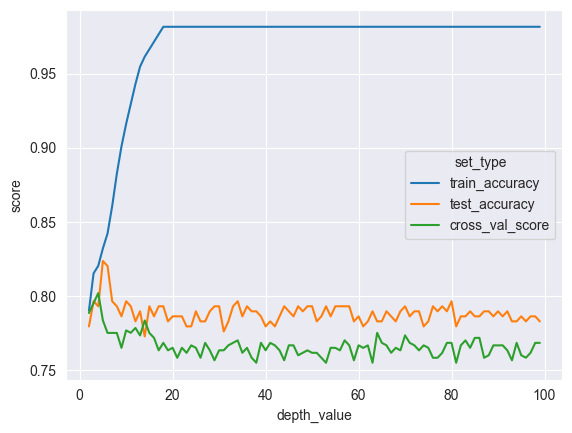

In [6]:
# Подбор параметром модели (тупой способ)
from tqdm.notebook import tqdm

results = pd.DataFrame(columns=['depth_value', 'train_accuracy', 'test_accuracy', 'cross_val_score'])
metrics = pd.DataFrame(columns=['depth_value', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score'])

for depth_value in tqdm(range(2, 100)):
    cls = tree.DecisionTreeClassifier(criterion='entropy', max_depth=depth_value)
    mean_cross_val_score = cross_val_score(cls, X_train, y_train, cv=5).mean()

    cls.fit(X_train, y_train)
    results = pd.concat(objs=[results, pd.DataFrame({"depth_value": [depth_value],
                                                     "train_accuracy": [cls.score(X_train, y_train)],
                                                     "test_accuracy": [cls.score(X_test, y_test)],
                                                     "cross_val_score": [mean_cross_val_score]})])

    metrics = pd.concat(objs=[metrics, pd.DataFrame({"depth_value": [depth_value],
                                                     "accuracy_score": [accuracy_score(y_test, cls.predict(X_test))],
                                                     "precision_score": [precision_score(y_test, cls.predict(X_test))],
                                                     "recall_score": [recall_score(y_test, cls.predict(X_test))],
                                                     "f1_score": [f1_score(y_test, cls.predict(X_test))]})])

results_long = pd.melt(frame=results, id_vars=['depth_value'],
                       value_vars=['train_accuracy', 'test_accuracy', 'cross_val_score'],
                       var_name='set_type', value_name='score')

sns.lineplot(data=results_long, x='depth_value', y='score', hue='set_type')
results[results['cross_val_score'] == results['cross_val_score'].max()]

,depth_value,score_type,score
0,2,accuracy_score,0.779661
1,3,accuracy_score,0.796610
2,4,accuracy_score,0.793220
3,5,accuracy_score,0.823729
4,6,accuracy_score,0.820339
...,...,...,...
387,95,f1_score,0.698565
388,96,f1_score,0.692308
389,97,f1_score,0.695652
390,98,f1_score,0.695652


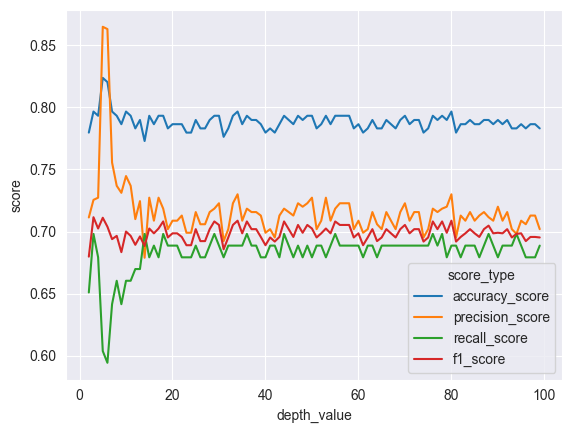

In [21]:
metrics_long = pd.melt(frame=metrics, id_vars=['depth_value'],
                       value_vars=['accuracy_score', 'precision_score', 'recall_score', 'f1_score'],
                       var_name='score_type', value_name='score')

sns.lineplot(data=metrics_long, x='depth_value', y='score', hue='score_type')
metrics_long

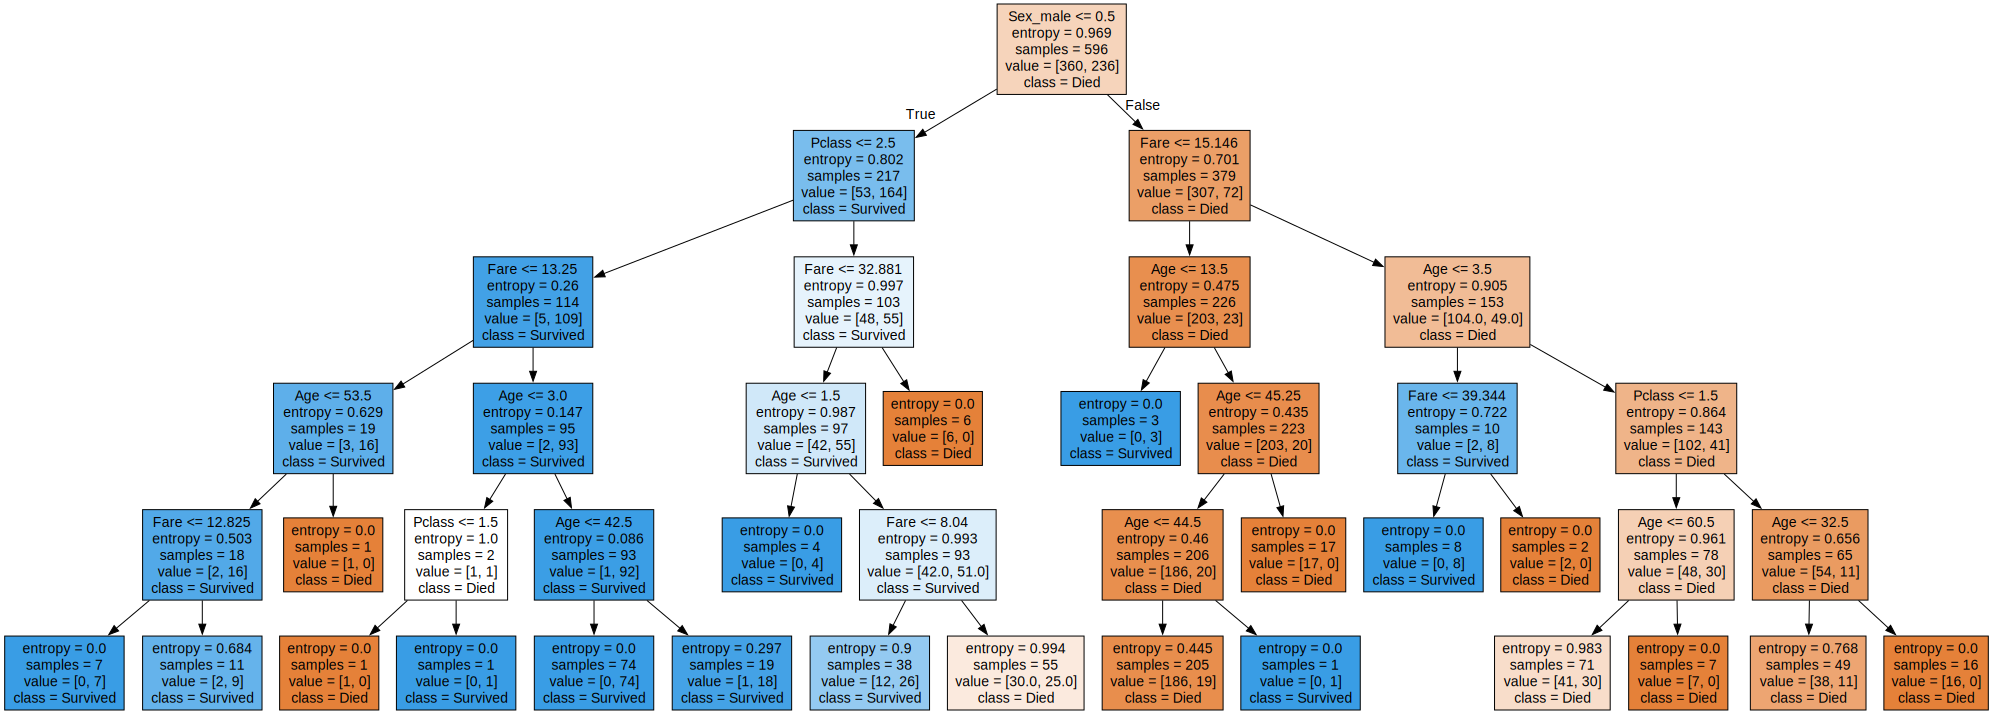

In [8]:
# Визуализируем модель
from IPython.display import SVG, display, HTML
from graphviz import Source

style = "<style>svg{width: 20% !important; height : 20% ! important; }</style>"
HTML(style)

graph = Source(tree.export_graphviz(model,
                                    out_file=None,
                                    feature_names=X_test.columns,
                                    class_names=['Died', 'Survived'],
                                    filled=True))

display(SVG(graph.pipe(format='svg')))

In [9]:
# Создаём модель с лучшими данными (тупой способ)
best_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
best_clf.fit(X_train, y_train)
best_clf.score(X_test, y_test)

0.8203389830508474

In [16]:
# Подбор параметром модели (умный способ)
from sklearn.model_selection import GridSearchCV

model_v2 = tree.DecisionTreeClassifier()

parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(3, 10), 'min_samples_leaf': range(50,120),
              'min_samples_split': range(10, 80)}

GS_clf = GridSearchCV(model_v2, param_grid=parameters, cv=5)
GS_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(3, 10),
                         'min_samples_leaf': range(50, 120),
                         'min_samples_split': range(10, 80)})

In [17]:
best_parameters = GS_clf.best_params_
best_model = GS_clf.best_estimator_

best_model.score(X_test, y_test)
# best_parameters

0.8169491525423729

<Axes: >

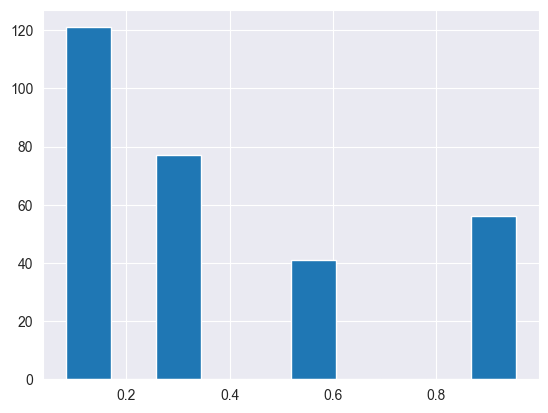

In [12]:
# Внутри дерева хранятся вероятности принадлежности объекта к одному из классов. 
# Как выбрать пороговые значения? Для этого использует ROC (Receiver  operating characteristic)
classes = best_model.classes_
# Порядок вероятностей соответствует порядку классов, определенному в обученной модели.
y_predicted_prob = best_model.predict_proba(X_test)
pd.Series(y_predicted_prob[:, 1]).hist()

In [13]:
# Подбираем пороговое значение вручную (говно)
y_pred = np.where(y_predicted_prob[:, 1] > 0.3, 1, 0)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision, recall

(0.5114942528735632, 0.839622641509434)

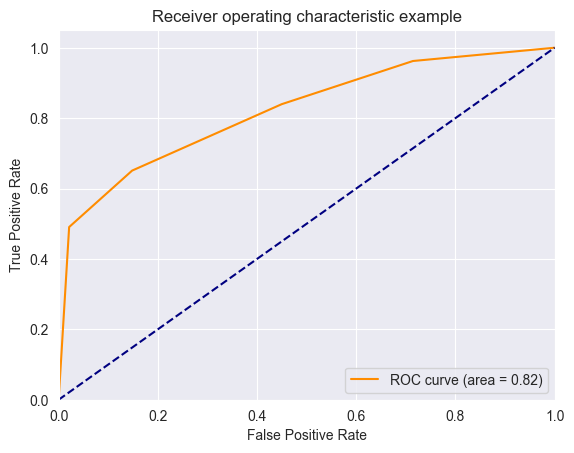

In [14]:
# ROC - Receiver  operating characteristic

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [15]:
root_node = 0  # индекс корня дерева
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

l_node = model.tree_.children_left[root_node]  # индекс корня левого поддерева
r_node = model.tree_.children_right[root_node]  # индекс корня правого поддерева

n0 = model.tree_.n_node_samples[root_node]  # количество сэмплов в корне поддереве
n1 = model.tree_.n_node_samples[l_node]  # количество сэмплов в левом поддереве
n2 = model.tree_.n_node_samples[r_node]  # количество сэмплов в правом поддереве

e0 = model.tree_.impurity[root_node]  # энтропия в корне дерева
e1 = model.tree_.impurity[l_node]  # энтропия в корне левого поддерева
e2 = model.tree_.impurity[r_node]  # энтропия в корне правого поддерева

information_gain = e0 - (n1 / n0 * e1 + n2 / n0 * e2)
information_gain

0.14823200099044143